# Tutorial: GPFA (Gaussian Process Factor Analysis)

Gaussian-process factor analysis (GPFA) is a dimensionality reduction method
[1] for neural trajectory visualization of parallel spike trains. GPFA applies
factor analysis (FA) to time-binned spike count data to reduce the
dimensionality and at the same time smoothes the resulting low-dimensional
trajectories by fitting a Gaussian process (GP) model to them.

The input consists of a set of trials ($Y$), each containing a list of spike
trains (N neurons). The output is the projection ($X$) of the data in a space
of pre-chosen dimensionality $x_{dim} < N$.

Under the assumption of a linear relation (transform matrix $C$) between the
latent variable $X$ following a Gaussian process and the spike train data $Y$ with
a bias $d$ and a noise term of zero mean and (co)variance $R$ (i.e.,
$Y = C X + d + \mathcal{N}(0,R)$), the projection corresponds to the
conditional probability $E[X|Y]$.
The parameters $(C, d, R)$ as well as the time scales and variances of the
Gaussian process are estimated from the data using an expectation-maximization
(EM) algorithm.

Internally, the analysis consists of the following steps:

0. bin the spike train data to get a sequence of $N$ dimensional vectors of spike counts in respective time bins, and choose the reduced dimensionality $x_{dim}$

1. expectation-maximization for fitting the parameters $C, d, R$ and the time scales and variances of the Gaussian process, using all the trials provided as input (c.f., `gpfa_core.em()`)

2. projection of single trials in the low dimensional space (c.f., `gpfa_core.exact_inference_with_ll()`)

3. orthonormalization of the matrix $C$ and the corresponding subspace, for visualization purposes: (c.f., `gpfa_core.orthonormalize()`)


## 1. Use Trial classes with GPFA

This tutorial illustrates the usage of Elephants trial classes with `gpfa.GPFA()`. This is used as a working notebook to test the integration of the trial object with GPFA.

### 1.1. Generation of synthetic spike trains

A set of spike trains are generated as follows.
First, a time series of either a 2-dimensional harmonic oscillator (Section 2)  is projected into a high-dimensional space (as high dimension as the desired number of parallel spike trains) via a random projection.
Then the resulting high-dimensional time series serves as time-dependent rates for an inhomogeneous multivariate Poisson process.
Finally, multiple realizations of this Poisson process, which mimic spike trains from multiple trials, serve as input data to the GPFA.

Below are the functions used for spike train generation:

In [2]:
# pip install 

In [3]:
import numpy as np
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.trials import TrialsFromLists
from elephant.gpfa import GPFA

def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

## 2. Harmonic Oscillator Example

In this first example we apply the GPFA to spike train data derived from dynamics of a harmonic oscillator defined in a 2-dimensional latent variable space. The aim is to extract these 2-dimensional latent dynamics from the spike train data.

### 2.1. Generate synthetic spike train data
Here we generate 50-dimensional synthetic spike train data based on a trajectory of a 2-dimensional harmonic oscillator, as described in Section 1.1.

In [4]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

Let's see how the trajectory and the spike trains look like.

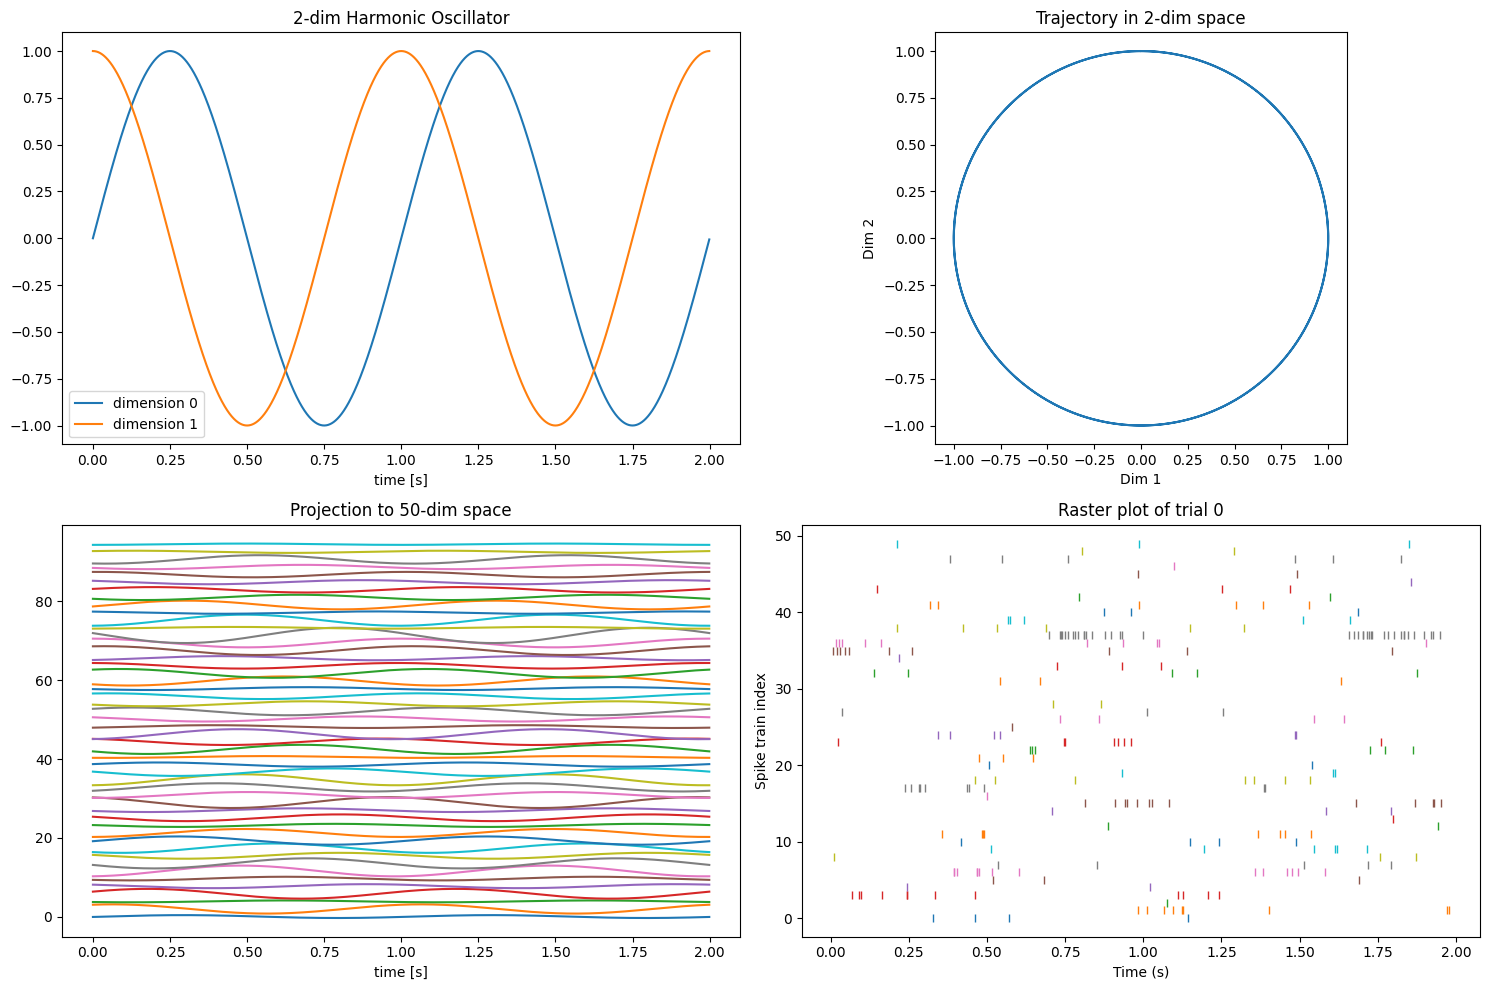

In [5]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

Thus, we have generated 50-dimensional spike train data, derived from 2-dimensional latent dynamics, i.e., two cycles of circular rotation.

## 2.2. Use Trial object to represent data

In [6]:
all_trials = TrialsFromLists(spiketrains_oscillator[:])
print(f"Number of trials: {all_trials.n_trials}")
print(f"Number of spiketrains per trial: {all_trials.n_spiketrains_trial_by_trial}")
print(f"Number of analog signals per trial: {all_trials.n_analogsignals_trial_by_trial}")

Number of trials: 20
Number of spiketrains per trial: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Number of analog signals per trial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
first_half_of_trials = TrialsFromLists(spiketrains_oscillator[:num_trials//2])
print(f"Number of trials: {first_half_of_trials.n_trials}")
print(f"Number of spiketrains per trial: {first_half_of_trials.n_spiketrains_trial_by_trial}")
print(f"Number of analog signals per trial: {first_half_of_trials.n_analogsignals_trial_by_trial}")

Number of trials: 10
Number of spiketrains per trial: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Number of analog signals per trial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
second_half_of_trials = TrialsFromLists(spiketrains_oscillator[num_trials//2:])
print(f"Number of trials: {second_half_of_trials.n_trials}")
print(f"Number of spiketrains per trial: {second_half_of_trials.n_spiketrains_trial_by_trial}")
print(f"Number of analog signals per trial: {second_half_of_trials.n_analogsignals_trial_by_trial}")

Number of trials: 10
Number of spiketrains per trial: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Number of analog signals per trial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 2.3. Apply GPFA to the generated data
Now we try to extract the original latent dynamics from the generated spike train data, by means of GPFA.

We first initialize an instance of the `gpfa.GPFA()` class.
One can specify some parameters for model fitting at this timing.
Here we set the size of the bin for spike train binning to 20 ms, and the dimensionality of latent variables to 2.

In [9]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

Then we call the `fit()` method of the class, with the generated spike train data as input.
This fits a GPFA model to the given data, yielding estimates of the model parameters that best explain the data, which are stored in the `params_estimated` attribute of the class.
Here we use the first half of the trials for fitting.

In [10]:
gpfa_2dim.fit(first_half_of_trials)
print(gpfa_2dim.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...


dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


Then we transform the spike trains from the remaining half of the trials into trajectories in the latent variable space, using the `transform()` method.

In [11]:
trajectories = gpfa_2dim.transform(second_half_of_trials)

Let's see how the extracted trajectories look like.

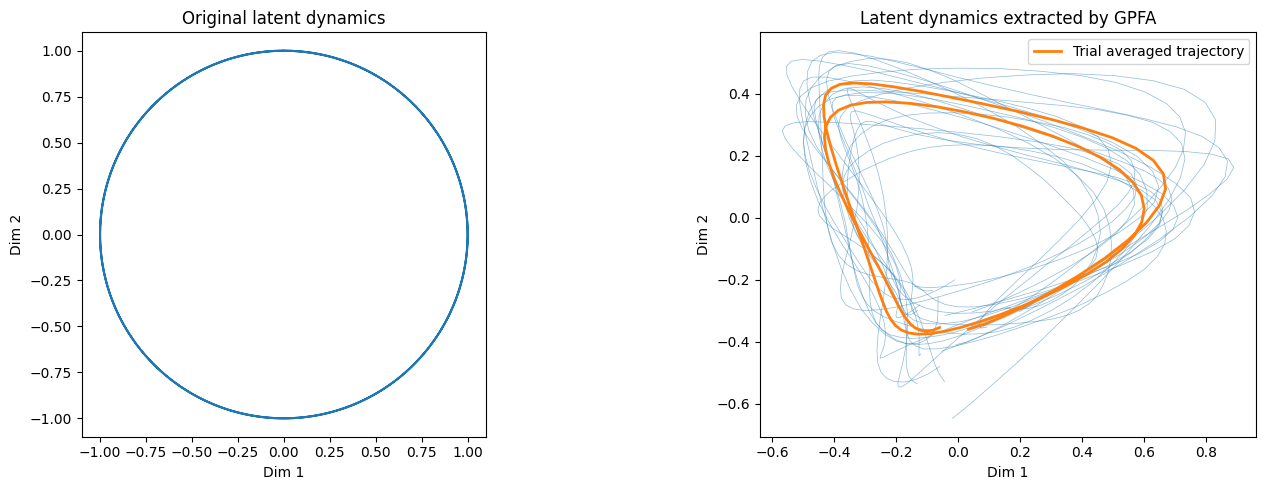

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

GPFA successfuly extracted, as the trial averaged trajectory, the two cycles of rotation in 2-dimensional latent space from the 50-dimensional spike train data.

In the above application we split the trials into two halves and performed fitting and transforming separately on these two sets of trials.
One can also simply perform fitting and transforming on the whole dataset to obtain latent trajectories for all trials.
In such a scenario, the `fit_transform()` method can be used to perform the fitting and transforming at once, as shown in the example below.

Initializing parameters using factor analysis...

Fitting GPFA model...


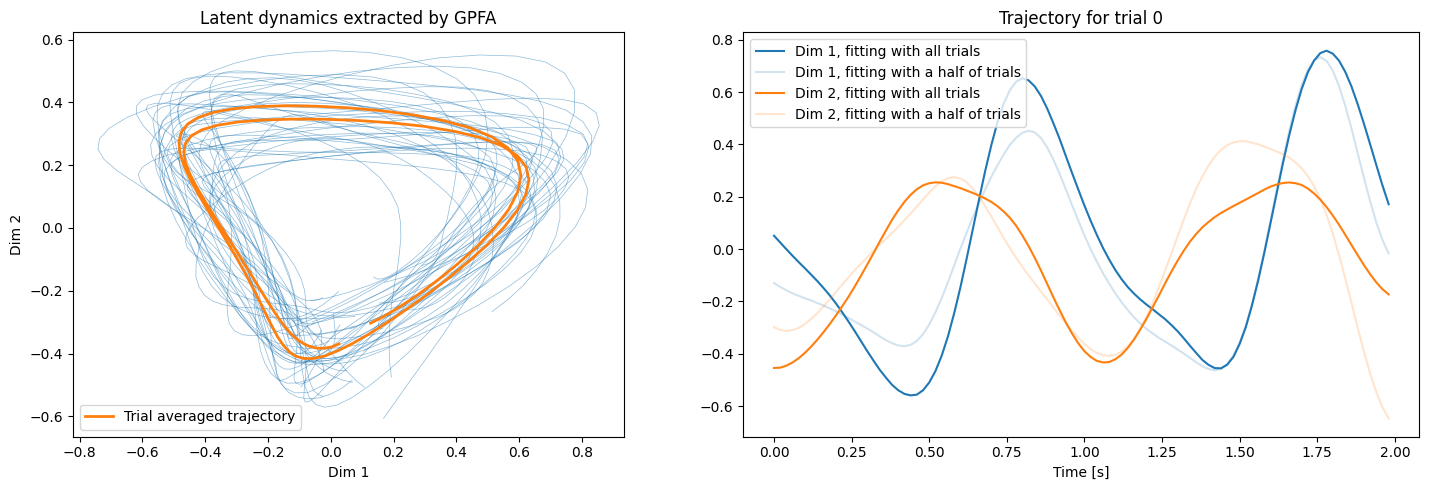

In [13]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(all_trials)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

We obtain almost the same latent dynamics, but single trial trajectories are slightly modified owing to an increased amount of the data used for fitting.

## Test score

In [14]:
score = gpfa_2dim.score(all_trials)
print(f"The score for all trials is: {score}")

The score for all trials is: 20618.70255156764


# References

[1] Yu MB, Cunningham JP, Santhanam G, Ryu SI, Shenoy K V, Sahani M (2009) Gaussian-process factor analysis for low-dimensional single-trial analysis of neural population activity. J. Neurophysiol. 102:614-635.

[2] Pandarinath, C. et al. (2018) Inferring single-trial neural population dynamics using sequential auto-encoders. Nat. Methods 15:805–815.

[3] Viswanath, D (2004) The fractal property of the Lorenz attractor. Physica D 190(1-2):115-128.